In [1]:
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pylab as plt

In [2]:
from numba import jit

In [3]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel2, SampleModel3, SampleModel4
from dissipationtheory.dissipation9a import K, Kmetal
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel2Jit, SampleModel3Jit, SampleModel4Jit
from dissipationtheory.dissipation9b import integrand1jit, integrand2jit, integrand3jit
from dissipationtheory.dissipation9b import Kmetal_jit, K_jit
from dissipationtheory.dissipation10e import rpIII_jit, KmatrixIII_jit, KmatrixIV_jit

In [4]:
from dissipationtheory.dissipation10e import twodimCobject

First, tweak the code in `test_dissipation9b.py` run in the Jupyter notebook environment.  This tweak involves changing

    self.params1_jit = ...
    
to

    self = {}
    ... 
    self['params1_jit'] = ...
    
and so on.  We also need to set 

    z_r = ureg.Quantity(1, 'nm')
    
so that our the `K_jit` results agree with the `KmatrixIII_jit` results.

# Setup

Define parameters common to all the upcoming simulations. \
A dictionary to hold the simulation parameters.

In [5]:
self = {}

A common cantilever object.

In [6]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(55, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm')
)

The frequency $\omega$.

In [7]:
omega = 1e4

Two locations to compute the $K_{n}$ integrals at.  \
We want versions of the location vectors in nanometers and in meters.

In [8]:
loc1_nm = np.array([ 0,  0, 50], dtype=np.float64)
loc2_nm = np.array([ 0,  0, 50], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

# Type IV sample

Calculate the three $K_{n}$ numbers for Sample 4 using the `Kmetal_jit` and `KmatrixIV_jit` functions. This code is adapted from the `def test_Sample4(self)` function in `test_dissipation9b.py` function.

Do the `Kmetal_jit` calculation first:

In [9]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(1, 'nm'))

self['params4_jit'] = {
    'sample': SampleModel4Jit(**sample4.args()), 
    'location1': loc1_m, 
    'location2': loc2_m}

In [10]:
K0, K1, K2 = Kmetal_jit(**self['params4_jit'])

result1a = np.array([K0, K1, K2])
result1a

array([1.e-02-0.j, 1.e-04+0.j, 2.e-06-0.j])

Now the `KmatrixIIV_jit` calculation:

In [11]:
K0, K1, K2 = KmatrixIV_jit(
    np.array([loc1_m]),
    np.array([loc2_m]))

result1b = np.array([K0[0][0]/1e9, K1[0][0]/1e18, K2[0][0]/1e27])
result1b

array([1.e-02+0.j, 1.e-04+0.j, 2.e-06-0.j])

Check that the real and imaginary parts of the two results are within rounding error.

In [12]:
(np.allclose(result1a.real, result1b.real), 
 np.allclose(result1a.imag, result1b.imag))

(True, True)

# Type V sample

Compare $K_{n}$'s. for a metal sample, computed with `Kmetal_jit` to a Type III sample with large dielectric constant, conductivity, and charge density, computed with `KmatrixIII_jit`.


First, recompute the metal case.

In [13]:
K0, K1, K2 = Kmetal_jit(**self['params4_jit'])

result2a = np.array([K0, K1, K2])
result2a

array([1.e-02-0.j, 1.e-04+0.j, 2.e-06-0.j])

Now perform the Type III sample calculation. \
Create a semi-infinite metal-like semiconductor.

In [14]:
sample5 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(1e6, 0), ''),
    sigma = ureg.Quantity(1e7, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample5_jit = SampleModel3Jit(**sample5.args())

In [15]:
self['params5_jit'] = {
    'integrand': integrand3jit, 
    'sample': sample5_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [16]:
j0s = scipy.special.jn_zeros(0,100.)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    'omega': omega, 
    'omega0': self['params5_jit']['sample'].omega0,
    'kD': self['params5_jit']['sample'].kD, 
    'es': self['params5_jit']['sample'].epsilon_s, 
    'sj': np.array([loc1_nm]), 
    'rk': np.array([loc2_nm]), 
    'j0s': j0s,
    'an': an}

K0, K1, K2 = KmatrixIII_jit(**args)

result2b = np.array([K0[0][0], K1[0][0], K2[0][0]])
result2b

array([9.99998930e-03-5.23707380e-17j, 9.99995377e-05-1.00400329e-19j,
       2.00003104e-06-9.49886494e-22j])

Compare the results.

In [17]:
(np.allclose(result1a.real, result1b.real),
 np.allclose(result2a.imag, result2b.imag))

(True, True)

This agreement shows that the integrator is working ok.

# Type III sample

Now compare a Type III sample computed with the `K_jit` and `KmatrixIII_jit` functions.

Reset the position vectors.

In [18]:
loc1_nm = np.array([  0,  0, 50], dtype=np.float64)
loc2_nm = np.array([  0,  0, 50], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

Create a semiconductor sample.

In [19]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm')
)

sample3_jit = SampleModel3Jit(**sample3.args())

In [20]:
self['params3_jit'] = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

Compute the $K_n$'s using ` K_jit`:

In [21]:
K0, K1, K2 = K_jit(**self['params3_jit'])

result3a = np.array([K0, K1, K2])
result3a

array([9.06022060e-03+5.30760987e-05j, 9.06526562e-05+6.53340400e-07j,
       1.81323170e-06+1.49191898e-08j])

Repeat $K_{n}$ calculation using `KmatrixIII_jit`:

In [22]:
j0s = scipy.special.jn_zeros(0,100.)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    'omega': omega, 
    'omega0': self['params3_jit']['sample'].omega0,
    'kD': self['params3_jit']['sample'].kD, 
    'es': self['params3_jit']['sample'].epsilon_s, 
    'sj': np.array([loc1_nm]), 
    'rk': np.array([loc2_nm]), 
    'j0s': j0s,
    'an': an}

K0, K1, K2 = KmatrixIII_jit(**args)

result3b = np.array([K0[0][0], K1[0][0], K2[0][0]])
result3b

array([9.05983710e-03+5.31090865e-05j, 9.06466361e-05+6.61758424e-07j,
       1.81333836e-06+1.51628337e-08j])

In contrast with the metal case, the agreement is not quantitative.

In [23]:
(np.allclose(result3a.real, result3b.real),
 np.allclose(result3a.imag, result3b.imag))

(False, False)

How close are the results?  \
Compute the fractional error for the real parts of the three integrals.

In [24]:
(result3b.real - result3a.real)/result3a.real

array([-4.23277677e-05, -6.64074621e-05,  5.88230598e-05])

Compute the fractional error for the imaginary parts of the three integrals.

In [25]:
(result3b.imag - result3a.imag)/result3a.imag

array([0.00062152, 0.01288459, 0.0163309 ])

Why the large discrepancy when $x = 0$ and $y = 0$?

# Examine the integrand

In [26]:
loc1_nm = np.array([  0,  0, 50], dtype=np.float64)
loc2_nm = np.array([  0,  0, 50], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

In [27]:
zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

y_array = np.linspace(0, 20., 100)
r_array = np.zeros_like(y_array, dtype=np.complex128)

for index, (r, y) in enumerate(zip(r_array, y_array)):
    
    args = {
        'y': y,
        'omega': omega, 
        'omega0': self['params3_jit']['sample'].omega0,
        'zr': zjkref,
        'kD': self['params3_jit']['sample'].kD, 
        'es': self['params3_jit']['sample'].epsilon_s}


    r_array[index] = scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y)

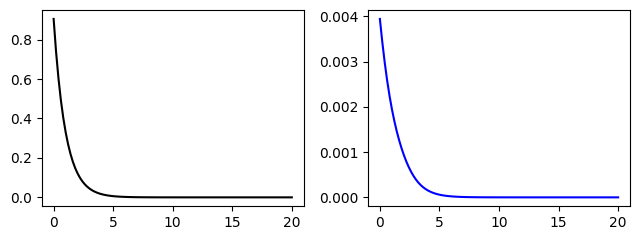

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6.5,2.5))
ax1.plot(y_array, np.real(r_array), 'k-', label='real')
ax2.plot(y_array, np.imag(r_array), 'b-', label='imag')
fig.tight_layout()
plt.show()

# Think about revising `KmatrixIII_jit`

For small $x$, when there are no Bessel function zeros in the interval, add more breakpoints. \
Five or six is probably a nice total number.

Let's recapitulate the breakpoint calculation in `KmatrixIII_jit`. \
We already computed `j0s` above. \
Pick the two locations so we have 0, 1, or 2 Bessel function zeros in the interval.

In [29]:
loc1_nm = np.array([ 0,  13, 50], dtype=np.float64)
loc2_nm = np.array([  0,  0, 50], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

In [30]:
y_min = 1.0e-7
y_max = 20.0
N = len(an) - 1

zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

mask = j0s/(x + 1.0e-6) < y_max
yb = np.hstack(
    (np.array([y_min]),
     j0s[mask] / x,
     np.array([y_max])))

print('breakpoints:', yb)

breakpoints: [1.00000000e-07 1.84986581e+01 2.00000000e+01]


We don't want too many breakpoints.

Play with adding them "by hand".  \
If there are just two breakpoints, add three more in the middle, that's obvious. \
But what about intermediate cases? \
In the code below, if there are three breakpointst, add another in between each.

In [31]:
def ripen(yb):

    if len(yb) == 2:
        yb = np.insert(yb, 1, np.linspace(yb[0], yb[1], 5)[1:-1]) # now 5 long
        
    if len(yb) == 3:
        yb = np.insert(yb, 1, np.linspace(yb[0], yb[1], 3)[1:-1]) # now 4 long
        print(yb)
        yb = np.insert(yb, 3, np.linspace(yb[2], yb[3], 3)[1:-1]) # now 5 long
                   
    return yb

This looks good.

In [32]:
ripen(np.array([1e-7, 20.]))

array([1.00000000e-07, 5.00000007e+00, 1.00000000e+01, 1.50000000e+01,
       2.00000000e+01])

As $x$ gets large, the first zero will appear.  \
The above algorithm then does enot give us the breakpoints we want. \
We need more at lower $y$ values.

In [33]:
ripen(np.array([1e-7, 1.84986581e+01, 20.]))

[1.00000000e-07 9.24932910e+00 1.84986581e+01 2.00000000e+01]


array([1.00000000e-07, 9.24932910e+00, 1.84986581e+01, 1.92493291e+01,
       2.00000000e+01])

So think again. \
Start out with five breakpoints in the $y \in (0,20)$ interval. \
Add additional breakpoints at Bessel function zeros. \
Sort the resulting array of breakpoints.


In [34]:
y_min = 1.0e-7
y_max = 20.0
N = len(an) - 1

zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

mask = j0s/(x + 1.0e-6) < y_max
zero_y_locations = j0s[mask] / x
yb = np.hstack(
    (np.linspace(y_min, y_max, 6), 
     zero_y_locations))
yb = np.sort(yb)


print('breakpoints:', yb)

breakpoints: [1.00000000e-07 4.00000008e+00 8.00000006e+00 1.20000000e+01
 1.60000000e+01 1.84986581e+01 2.00000000e+01]


# Revised `KmatrixIII_jit` function

Based on this new breakpoint algorithm, write a revised `KmatrixIII_jit` function.

In [35]:
@jit(nopython=True)
def KmatrixIII_jit_new(omega, omega0, kD, es, sj, rk, j0s, an):
    """The unitless response-function matrices for a Type III semiconductor sample."""

    y_min = 1.0e-7
    y_max = 20.0
    N = len(an) - 1
    
    K0 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K1 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K2 = np.zeros((len(sj),len(rk)), dtype=np.complex128)

    # Loop over image-charge points
    
    for k, rke in enumerate(rk):    

        # Loop over voltage-test points
        
        for j, sje in enumerate(sj):

            zjkref = sje[2] + rke[2]
            x = np.sqrt((sje[0] - rke[0])**2 + (sje[1] - rke[1])**2) / zjkref

            # Determine breakpoints
            # START NEW CODE
            
            mask = j0s/(x + 1.0e-6) < y_max
            zero_y_locations = j0s[mask] / x
            yb = np.hstack(
                (np.linspace(y_min, y_max, 6), 
                 zero_y_locations))
            yb = np.sort(yb)
            
            # END NEW CODE
            
            result0 = np.zeros(len(yb)-1, dtype=np.complex128)
            result1 = np.zeros(len(yb)-1, dtype=np.complex128)
            result2 = np.zeros(len(yb)-1, dtype=np.complex128)

            # Loop over subintervals
            
            for index in np.arange(len(yb)-1):
                
                y_vector = np.linspace(yb[index], yb[index+1], N+1)
                dy = (yb[index+1] - yb[index])/N

                integral0 = np.zeros_like(y_vector, dtype=np.complex128)
                integral1 = np.zeros_like(y_vector, dtype=np.complex128)
                integral2 = np.zeros_like(y_vector, dtype=np.complex128)

                # Loop over y-axis points in the subinterval
                
                for m, y in enumerate(y_vector):

                    rp = rpIII_jit(y, omega, omega0, zjkref, kD, es)
                    
                    integral0[m] = np.exp(-y) * scipy.special.j0(y * x) * rp
                    integral1[m] = y * integral0[m]
                    integral2[m] = y * integral1[m]

                # Sum with Newton-Cotes weights
                
                result0[index] = dy * (an * integral0).sum()  
                result1[index] = dy * (an * integral1).sum()
                result2[index] = dy * (an * integral2).sum()

            K0[j,k] = result0.sum() / zjkref**1
            K1[j,k] = result1.sum() / zjkref**2
            K2[j,k] = result2.sum() / zjkref**3
            
    return K0, K1, K2

Test it!

In [36]:
loc1_nm = np.array([  0,  0, 50], dtype=np.float64)  # adjust these
loc2_nm = np.array([  0,  0, 50], dtype=np.float64)  # adjust these

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

self['params3_jit'] = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [37]:
%%timeit
K0, K1, K2 = K_jit(**self['params3_jit'])

3.29 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
K0, K1, K2 = K_jit(**self['params3_jit'])
result4a = np.array([K0, K1, K2])
result4a

array([9.06022060e-03+5.30760987e-05j, 9.06526562e-05+6.53340400e-07j,
       1.81323170e-06+1.49191898e-08j])

In [39]:
j0s = scipy.special.jn_zeros(0, 100.0)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    "omega": omega,
    "omega0": self["params3_jit"]["sample"].omega0,
    "kD": self["params3_jit"]["sample"].kD,
    "es": self["params3_jit"]["sample"].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

In [40]:
%%timeit
K0, K1, K2 = KmatrixIII_jit_new(**args)

37.3 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
K0, K1, K2 = KmatrixIII_jit_new(**args)
result4b = np.array([K0[0][0], K1[0][0], K2[0][0]])
result4b

array([9.06021967e-03+5.30761003e-05j, 9.06526523e-05+6.53340460e-07j,
       1.81323088e-06+1.49191814e-08j])

For a timing comparison

In [42]:
%%timeit
K0, K1, K2 = KmatrixIII_jit(**args)

7.92 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The added breakpoints have increased the run time by 3 to 6 fold (my timings are not very reproducible). \
The increase in run time will depends on the two locations.

Yahoo!  Both calculation methods give the same result.

In [43]:
(np.allclose(result4a.real, result4b.real), 
 np.allclose(result4a.imag, result4b.imag))

(True, True)

In [44]:
(result4b.real - result4a.real)/result4a.real

array([-1.02648456e-07, -4.29833202e-08, -4.53662364e-07])

In [45]:
(result4b.imag - result4a.imag)/result4a.imag

array([ 3.03042596e-08,  9.21173954e-08, -5.68749951e-07])

The accuracy for both the real *and* imaginary part of the $K_n$ integrals is better than a part per million. I conclude that my bespoke, compiled integration routine is giving essentially the same result as the `scipy.integrate` result.  My routine is 200-fold faster, however, than `scipy.integrate`.

# Test the new `KmatrixIII_jit` function

Create a new file `dissipation11e.py` that incorporates the improved breakpoint code in the `KmatrixIII_jit` function.  Read in the new code and run the above tests again.

In [46]:
from dissipationtheory.dissipation11e import KmatrixIII_jit

In [47]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(60, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'))

In [48]:
omega = 1e2

In [49]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 2), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

In [50]:
loc1_nm_array = np.array(
    [np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0, 20, 30], dtype=np.float64),
     np.array([  0, 30, 30], dtype=np.float64),
     np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0, 10, 20], dtype=np.float64),
     np.array([  0, 20, 20], dtype=np.float64)])

loc2_nm_array = np.array(
    [np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0,  0, 20], dtype=np.float64)])

for loc1_nm, loc2_nm in zip(loc1_nm_array, loc2_nm_array):

    print('')
    print('loc1 =', loc1_nm, 'loc2 =', loc2_nm)
    
    loc1_m = 1e-9 * loc1_nm
    loc2_m = 1e-9 * loc2_nm

    self['params3_jit'] = {
        'integrand': integrand3jit, 
        'sample': sample3_jit, 
        'omega': omega, 
        'location1': loc1_m, 
        'location2': loc2_m}

    K0, K1, K2 = K_jit(**self['params3_jit'])
    result5a = np.array([K0, K1, K2])

    j0s = scipy.special.jn_zeros(0, 100.0)
    an, _ = scipy.integrate.newton_cotes(20, 1)

    args = {
        "omega": omega,
        "omega0": self["params3_jit"]["sample"].omega0,
        "kD": self["params3_jit"]["sample"].kD,
        "es": self["params3_jit"]["sample"].epsilon_s,
        "sj": np.array([loc1_nm]),
        "rk": np.array([loc2_nm]),
        "j0s": j0s,
        "an": an}

    K0, K1, K2 = KmatrixIII_jit(**args)
    result5b = np.array([K0[0][0], K1[0][0], K2[0][0]])
    
    print(np.allclose(result5b.real, result5a.real, rtol=5e-3))  # half a percent tolerance
    
    for idx, (Ka, Kb) in enumerate(zip(result5a,result5b)):
        
        err_real = (Ka.real-Kb.real)/Ka.real        
        print('Re[K[{:d}]] {:0.6e} {:0.6e}, err = {:+0.2e}'.format(idx, Ka.real, Kb.real, err_real))
        
    print(np.allclose(result5b.imag, result5a.imag, rtol=5e-3)) # half a percent tolerance   
        
    for idx, (Ka, Kb) in enumerate(zip(result5a,result5b)):
        
        err_imag = (Ka.imag-Kb.imag)/Ka.imag
        print('Im[K[{:d}]] {:0.6e} {:0.6e}, err = {:+0.2e}'.format(idx, Ka.imag, Kb.imag, err_imag))        


loc1 = [ 0.  0. 30.] loc2 = [ 0.  0. 30.]
True
Re[K[0]] 1.545071e-02 1.545079e-02, err = -5.26e-06
Re[K[1]] 2.531507e-04 2.531502e-04, err = +2.06e-06
Re[K[2]] 8.403305e-06 8.403298e-06, err = +7.92e-07
True
Im[K[0]] 5.974889e-05 5.968994e-05, err = +9.87e-04
Im[K[1]] 2.141247e-06 2.141324e-06, err = -3.62e-05
Im[K[2]] 7.952707e-08 7.952893e-08, err = -2.33e-05

loc1 = [ 0. 20. 30.] loc2 = [ 0.  0. 30.]
True
Re[K[0]] 1.467440e-02 1.467448e-02, err = -5.56e-06
Re[K[1]] 2.163389e-04 2.163384e-04, err = +2.39e-06
Re[K[2]] 6.102284e-06 6.102280e-06, err = +6.43e-07
True
Im[K[0]] 5.242471e-05 5.236557e-05, err = +1.13e-03
Im[K[1]] 1.783656e-06 1.783734e-06, err = -4.37e-05
Im[K[2]] 5.694961e-08 5.695150e-08, err = -3.32e-05

loc1 = [ 0. 30. 30.] loc2 = [ 0.  0. 30.]
True
Re[K[0]] 1.385336e-02 1.385344e-02, err = -5.91e-06
Re[K[1]] 1.815121e-04 1.815116e-04, err = +2.83e-06
Re[K[2]] 4.215381e-06 4.215379e-06, err = +4.88e-07
True
Im[K[0]] 4.473420e-05 4.467482e-05, err = +1.33e-03
Im[K[1]] 

Speed test.

In [51]:
%%timeit
K0, K1, K2 = KmatrixIII_jit(**args)

48.4 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Thoughts

The integrand peaks at different locations for $K_0$, $K_1$, and $K_2$. \
I can probably further increase accuracy further by optimizing the integration breakpoints for each integrand independently.

# In preparation for further unit tests

In [52]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(100, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(1, 'nm'))

sample1_jit = SampleModel1Jit(**sample1.args())


self['params1_jit'] = {
    'integrand': integrand1jit, 
    'sample': sample1_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [53]:
%%timeit
K0, K1, K2 = K_jit(**self['params1_jit'])

6.96 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
K0, K1, K2 = K_jit(**self['params1_jit'])
result5a = np.array([K0, K1, K2])
result5a

array([2.08114571e-02-4.55663475e-06j, 4.08006850e-04-2.70617303e-08j,
       1.42034352e-05-2.55683146e-10j])

In [55]:
sample2 = SampleModel2(
    cantilever = cantilever,
    epsilon_d = ureg.Quantity(complex(3, 0), ''),
    h_d = ureg.Quantity(50, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))


sample2_jit = SampleModel2Jit(**sample2.args())

self['params2_jit'] = {
    'integrand': integrand2jit, 
    'sample': sample2_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [56]:
%%timeit
K0, K1, K2 = K_jit(**self['params2_jit'])

6.04 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
K0, K1, K2 = K_jit(**self['params2_jit'])
result6a = np.array([K0, K1, K2])
result6a

array([1.47365512e-02-3.96549684e-05j, 2.49132066e-04-8.51225563e-08j,
       8.18851022e-06-3.67869500e-10j])

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-62.ipynb && open dissipation-theory--Study-62.html
    
:::